# Q1. Graph-Based Image Segmentation using Normalized Cuts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import eigsh
from skimage import filters, io, transform
from skimage.color import rgb2gray
from sklearn.cluster import KMeans

## Load Dataset

In [2]:
dataset_path = "../dataset/q1/"
output_path = '../outputs/q1/'
size = (100, 100)

img1 = rgb2gray(io.imread(dataset_path + 'books.jpg'))
img2 = rgb2gray(io.imread(dataset_path + 'chess.jpg'))
img3 = rgb2gray(io.imread(dataset_path + 'football.jpg'))
img4 = rgb2gray(io.imread(dataset_path + 'zebra.jpg'))


images = [
        transform.resize(img1, size, anti_aliasing=True),
        transform.resize(img2, size, anti_aliasing=True),
        transform.resize(img3, size, anti_aliasing=True),
        transform.resize(img4, size, anti_aliasing=True),
    ]

image_names = ['Books', 'Chess', 'Football', 'Zebra']

/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_e

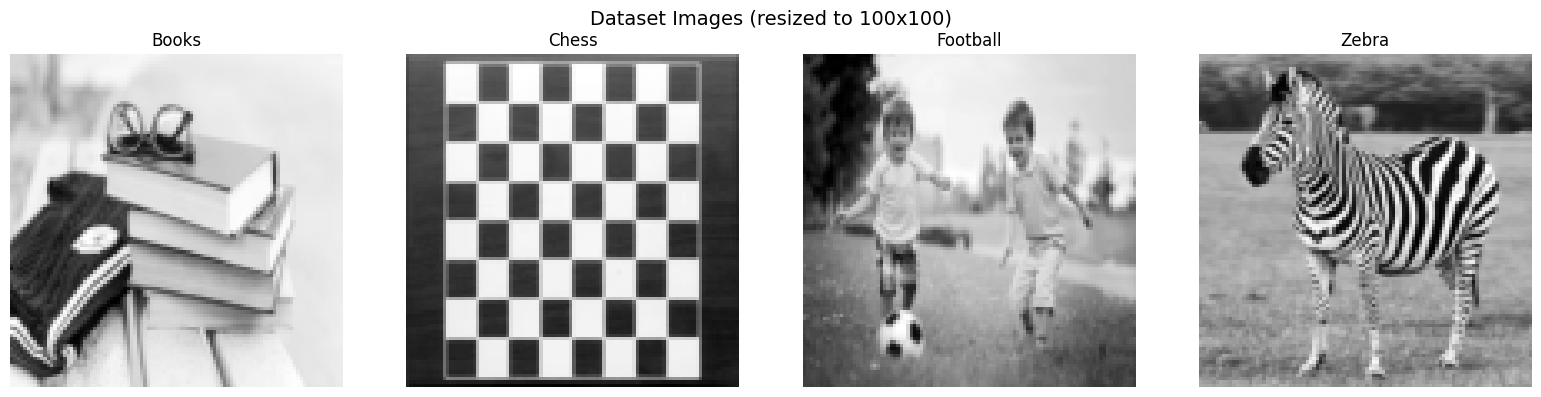

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, img, name in zip(axes, images, image_names):
    ax.imshow(img, cmap='gray')
    ax.set_title(name)
    ax.axis('off')
plt.suptitle('Dataset Images (resized to 100x100)', fontsize=14)
plt.tight_layout()
plt.show()

## Core N-Cut Implementation

In [4]:
def build_pixel_features(image):
    H, W = image.shape

    # pixel intensity
    I = image.flatten()  # (N,)
    
    # spatial location (normalized to [0,1])
    rows, cols = np.meshgrid(np.linspace(0, 1, H), np.linspace(0, 1, W), indexing='ij')
    X = np.stack([rows.flatten(), cols.flatten()], axis=1)  # (N, 2)
    
    return I, X

def compute_edge_strength(image):
    edges = filters.sobel(image)  # gradient mag
    return edges.flatten()  # (N,) edge strength at each pixel

def build_image_features(image, sigma_I=0.1, sigma_X=0.1, sigma_E=0.1):
    I, X = build_pixel_features(image)
    E = compute_edge_strength(image)   # shape (N,)

    # pixel intensity
    diff_I = I[:, None] - I[None, :]
    W_I = np.exp(-(diff_I ** 2) / sigma_I**2)

    # spatial location
    diff_X = X[:, None, :] - X[None, :, :]
    dist_X_sq = np.sum(diff_X ** 2, axis=-1)
    W_X = np.exp(-dist_X_sq / sigma_X**2)

    # edge strength
    E = E / (E.max() + 1e-8)
    E_ij = (E[:, None] - E[None, :]) # / 2.0
    W_E = np.exp(-(E_ij ** 2) / sigma_E**2)

    return W_I, W_X, W_E

In [5]:
def build_affinity_matrix_original(W_I, W_X):
    # affinity 
    W_dense = (W_I * W_X).astype(np.float32)
    np.fill_diagonal(W_dense, 0)
    
    # Force near-zero connections to absolute zero
    W_dense[W_dense < 1e-4] = 0.0

    # need to convert to sparse CSR for eigensolver compatibility
    W_mat = sparse.csr_matrix(W_dense)
    return W_mat

In [6]:
def build_affinity_matrix_edge_aware(W_I, W_X, W_E):
    W_dense = (W_I * W_X * W_E).astype(np.float32)
    np.fill_diagonal(W_dense, 0)

    W_dense[W_dense < 1e-4] = 0.0 
    
    W_mat = sparse.csr_matrix(W_dense)

    return W_mat

In [7]:
def compute_ncut(W, n_segments=2):
    # degree matrix
    d = np.array(W.sum(axis=1)).flatten()
    d = np.maximum(d, 1e-10)  # so that we avoid division by zero
    D_inv_sqrt = sparse.diags(1.0 / np.sqrt(d))
    
    # Normalized Laplacian: L_sym = D^{-1/2}(D-W)D^{-1/2}
    D = sparse.diags(d)
    L = D - W
    L_sym = D_inv_sqrt @ L @ D_inv_sqrt
    
    # Compute n_segments+1 smallest eigenvalues (skip eval 0)
    k = min(n_segments + 1, W.shape[0] - 2)
    eigenvalues, eigenvectors = eigsh(L_sym, k=k, which='SM', tol=1e-6, maxiter=1000)
    
    # Sort by eigenvalue
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Convert back: v = D^{-1/2} y
    eigenvectors = D_inv_sqrt @ eigenvectors
    
    return eigenvalues, eigenvectors

def ncut_two_way(W, image_shape):
    Heigth, Width = image_shape
    _, eigvecs = compute_ncut(W, n_segments=2)
    # Use 2nd smallest eigenvector
    v2 = eigvecs[:, 1]
    labels = (v2 >= 0).astype(int)
    return labels.reshape(Heigth, Width)

In [8]:
def align_labels(seg_ref, seg_other):
    agree    = np.mean(seg_ref == seg_other)
    disagree = np.mean(seg_ref != seg_other)
    return 1 - seg_other if disagree > agree else seg_other

def align_seg_list(segs):
    aligned = [segs[0]]
    for seg in segs[1:]:
        aligned.append(align_labels(segs[0], seg))
    return aligned

---
## Part (a): Original vs. Edge-Aware Affinity

In [9]:
SIGMA_I = 0.1
SIGMA_X = 0.5
SIGMA_E = 0.01

In [10]:
results_a = []

for img_idx in range(2):
    img = images[img_idx]
    name = image_names[img_idx]
    print(f"Processing '{name}'...")

    W_I, W_X, W_E = build_image_features(image=img, sigma_I=SIGMA_I, sigma_X=SIGMA_X, sigma_E=SIGMA_E)
    
    print(f"  Running N-Cut (original)...")
    W_original = build_affinity_matrix_original(W_I, W_X)
    seg_original = ncut_two_way(W_original, img.shape)
    
    print(f"  Running N-Cut (edge-aware)...")
    W_edge_aware = build_affinity_matrix_edge_aware(W_I, W_X, W_E)
    seg_edge_aware = ncut_two_way(W_edge_aware, img.shape)
    seg_edge_aware_aligned = align_labels(seg_original, seg_edge_aware)

    edges = filters.sobel(img)

    results_a.append((img, edges, seg_original, seg_edge_aware_aligned, name))

print("\nSegmentation complete.")

Processing 'Books'...
  Running N-Cut (original)...
  Running N-Cut (edge-aware)...
Processing 'Chess'...
  Running N-Cut (original)...
  Running N-Cut (edge-aware)...

Segmentation complete.


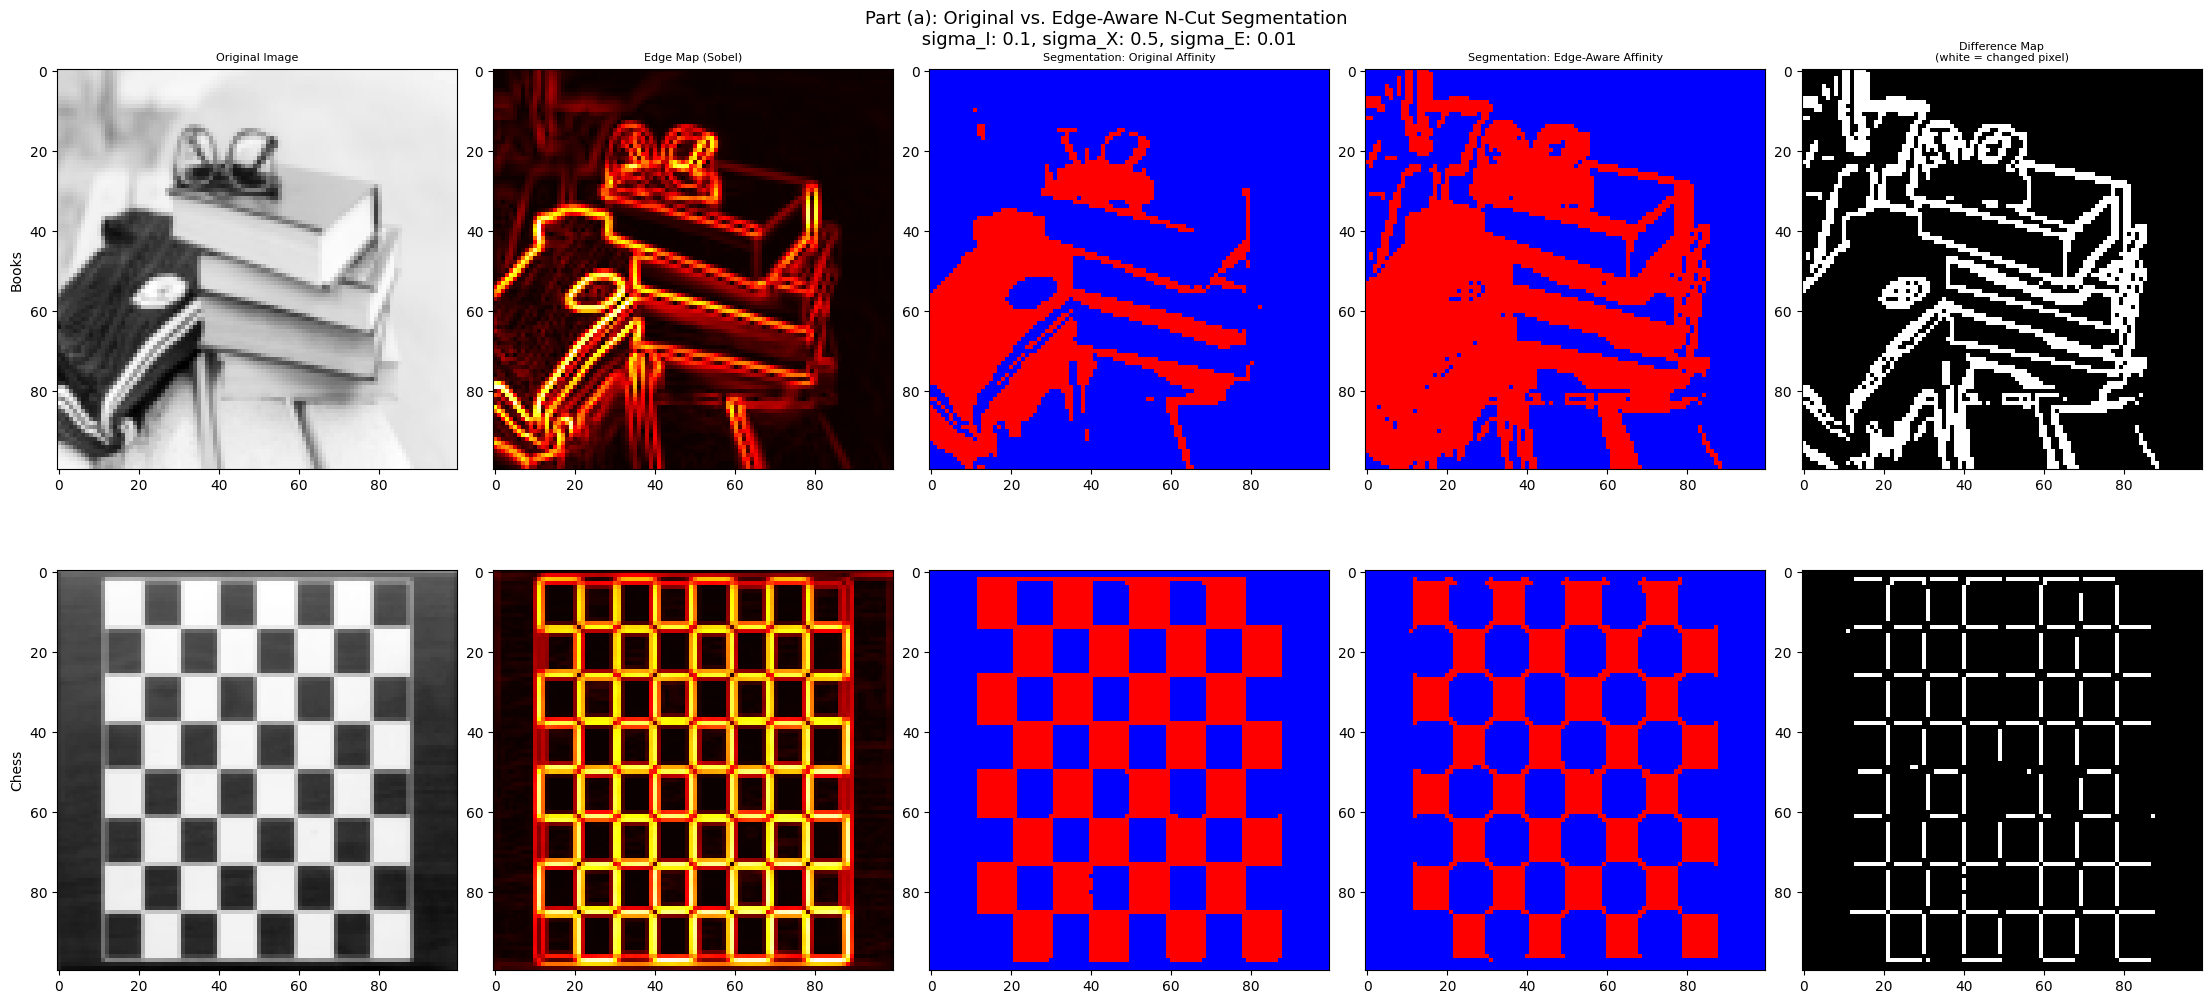

In [11]:
cmap_seg = plt.cm.bwr          # two-class: blue & red

col_titles = [
    'Original Image',
    'Edge Map (Sobel)',
    'Segmentation: Original Affinity',
    'Segmentation: Edge-Aware Affinity',
    'Difference Map\n(white = changed pixel)'
]

fig, axes = plt.subplots(len(results_a), 5, figsize=(22, 5 * len(results_a)), constrained_layout=True)
if len(results_a) == 1:
    axes = axes[np.newaxis, :]

for ax, t in zip(axes[0], col_titles):
    ax.set_title(t, fontsize=8)

for row, (img, edges, seg_orig, seg_edge, name) in enumerate(results_a):

    # col 0: image 
    axes[row, 0].imshow(img, cmap='gray')
    axes[row, 0].set_ylabel(name, fontsize=10)

    # col 1: edge map 
    axes[row, 1].imshow(edges, cmap='hot')

    # col 2: original segmentation 
    axes[row, 2].imshow(seg_orig, cmap=cmap_seg, vmin=0, vmax=1)

    # col 3: edge-aware segmentation
    axes[row, 3].imshow(seg_edge, cmap=cmap_seg, vmin=0, vmax=1)

    # col 4: difference map 
    diff = (seg_orig != seg_edge).astype(float)
    pct  = diff.mean() * 100
    axes[row, 4].imshow(diff, cmap='gray', vmin=0, vmax=1)

fig.suptitle(f'Part (a): Original vs. Edge-Aware N-Cut Segmentation\n sigma_I: {SIGMA_I}, sigma_X: {SIGMA_X}, sigma_E: {SIGMA_E}', fontsize=13, y=1.01)
plt.savefig(output_path+'part_a_results.png', dpi=100, bbox_inches='tight')
plt.show()

---
## Part (b): Effect of varying Sigma

In [ ]:
sigma_X_fixed = 0.5
sigma_I_values = [0.05, 0.1, 0.5, 0.8]

sigma_I_fixed = 0.1
sigma_X_values = [0.25, 0.5, 1, 1.5]

SIGMA_E = 0.01

In [13]:
def get_seg_maps_vary_sigma(img, fixed_sigma, vary_sigma_values, fixed_sigma_name, vary_sigma_name):
    print(f"    Varying {vary_sigma_name} with {fixed_sigma_name} = {fixed_sigma} fixed...")
    segs_original_list = []
    segs_modified_list = []
    for sigma in vary_sigma_values:
        print(f"        {vary_sigma_name} = {sigma}")

        if fixed_sigma_name == "sigma_X":
            W_I, W_X, W_E = build_image_features(image=img, sigma_I=sigma, sigma_X=fixed_sigma, sigma_E=SIGMA_E)
        else:
            W_I, W_X, W_E = build_image_features(image=img, sigma_I=fixed_sigma, sigma_X=sigma, sigma_E=SIGMA_E)

        W_original = build_affinity_matrix_original(W_I, W_X)
        seg_original = ncut_two_way(W_original, img.shape)
        segs_original_list.append(seg_original)

        W_modified = build_affinity_matrix_edge_aware(W_I, W_X, W_E)
        seg_modified = ncut_two_way(W_modified, img.shape)
        segs_modified_list.append(seg_modified)

    segs_original_list = align_seg_list(segs_original_list)
    segs_modified_list = align_seg_list(segs_modified_list)

    return segs_original_list, segs_modified_list

In [14]:
def plot_varying_sigma_effect(segs_vary_sigmaI, segs_vary_sigmaX, affinity="Original", filename='part_b_results.png'):
    cmap_seg = plt.cm.bwr

    fig, axes = plt.subplots(2, len(sigma_I_values) + 1, figsize=(18, 8), constrained_layout=True)

    # Row 0: vary sigma_I
    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].set_title('Original\nImage')
    axes[0, 0].axis('off')
    for j, (sI, seg) in enumerate(zip(sigma_I_values, segs_vary_sigmaI)):
        axes[0, j+1].imshow(seg, cmap=cmap_seg, vmin=0, vmax=1)
        axes[0, j+1].set_title(f'sigma_I = {sI}\n(sigma_X fixed={sigma_X_fixed})')
        axes[0, j+1].axis('off')
    axes[0, 0].set_ylabel('Varying sigma_I', fontsize=12, rotation=90, labelpad=10)

    # Row 1: vary sigma_X
    axes[1, 0].imshow(img, cmap='gray')
    axes[1, 0].set_title('Original\nImage')
    axes[1, 0].axis('off')
    for j, (sX, seg) in enumerate(zip(sigma_X_values, segs_vary_sigmaX)):
        axes[1, j+1].imshow(seg, cmap=cmap_seg, vmin=0, vmax=1)
        axes[1, j+1].set_title(f'sigma_X = {sX}\n(sigma_I fixed={sigma_I_fixed})')
        axes[1, j+1].axis('off')
    axes[1, 0].set_ylabel('Varying sigma_X', fontsize=12, rotation=90, labelpad=10)

    fig.suptitle(f'Part (b): Effect of sigma_I and sigma_X on {affinity} N-Cut Segmentation', fontsize=14)
    plt.savefig(output_path + filename, dpi=100, bbox_inches='tight')
    plt.show()

Processing image: Books
    Varying sigma_I with sigma_X = 0.5 fixed...
        sigma_I = 0.05
        sigma_I = 0.1
        sigma_I = 0.5
        sigma_I = 0.8
    Varying sigma_X with sigma_I = 0.1 fixed...
        sigma_X = 0.25
        sigma_X = 0.5
        sigma_X = 1
        sigma_X = 1.5


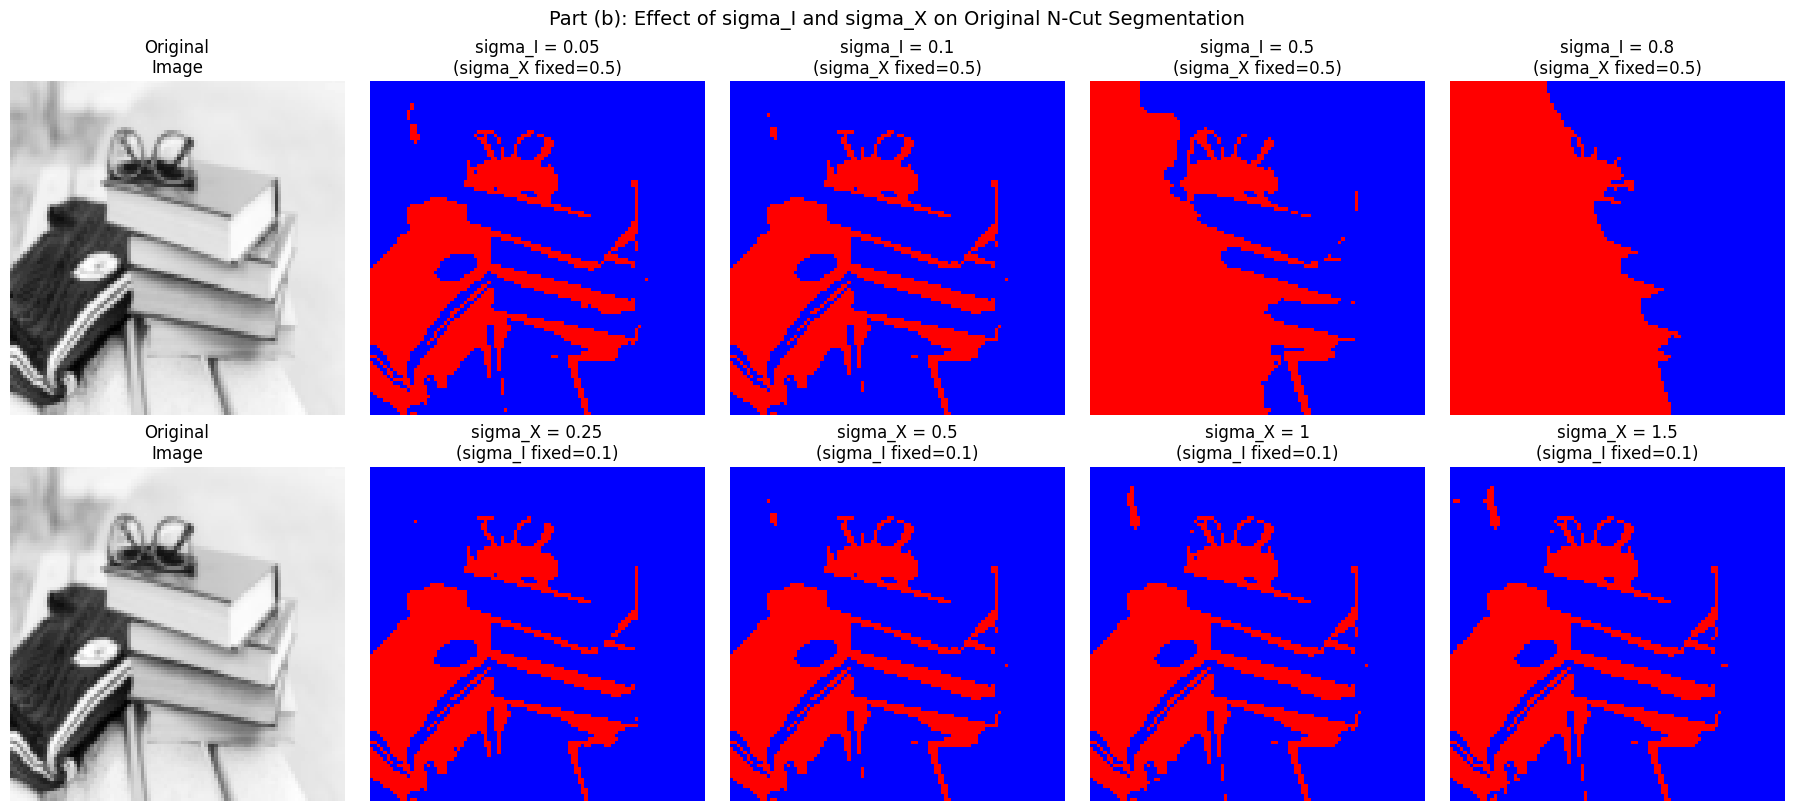

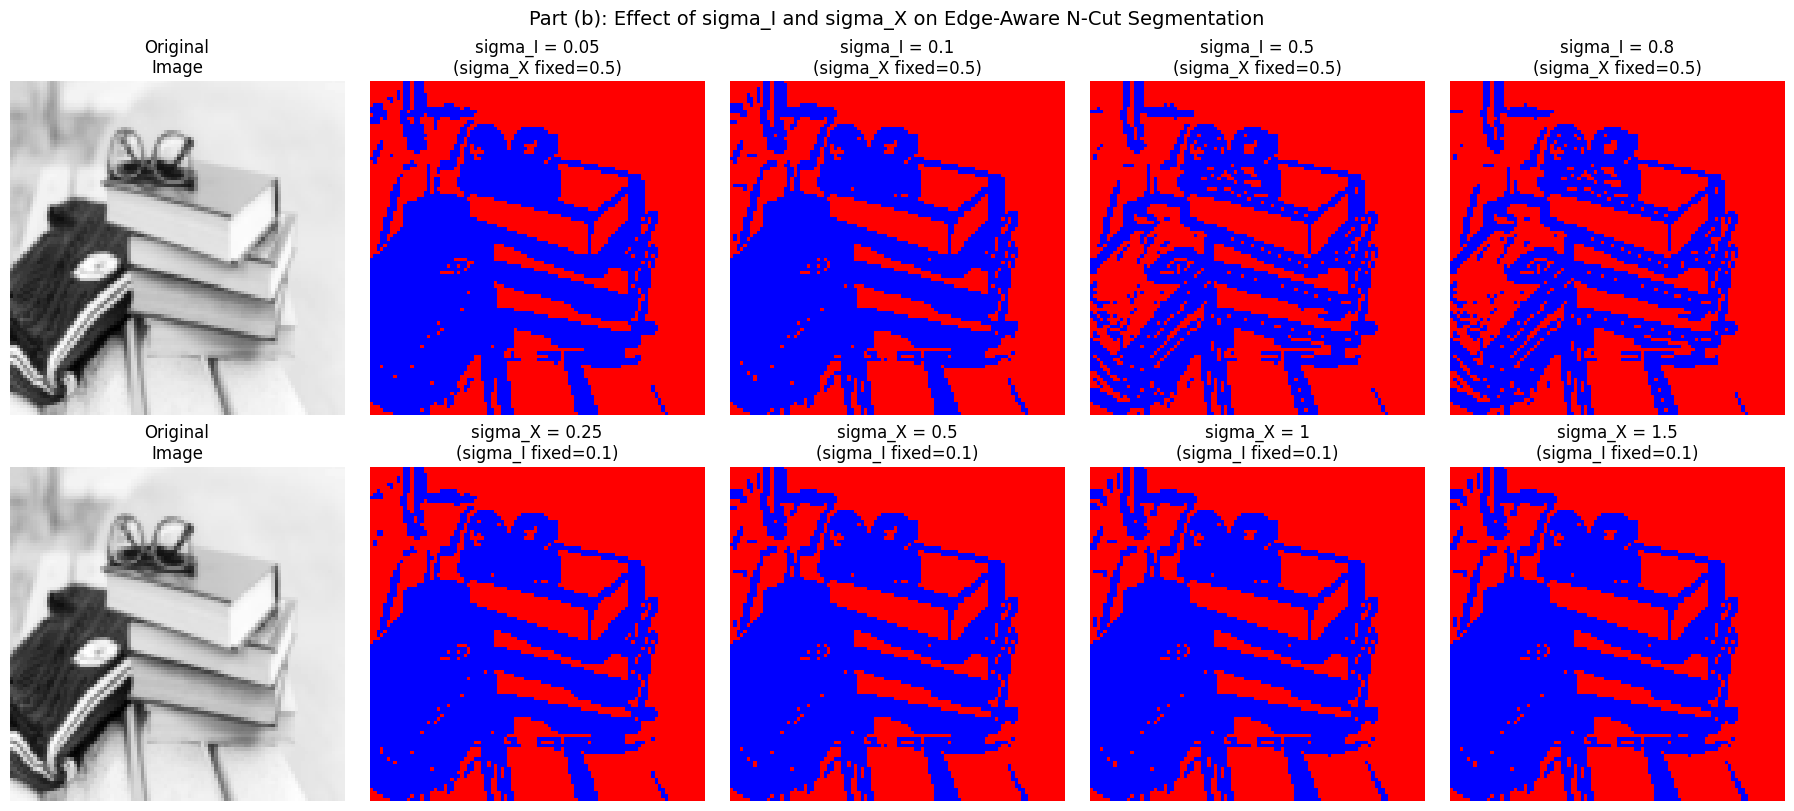

Processing image: Chess
    Varying sigma_I with sigma_X = 0.5 fixed...
        sigma_I = 0.05
        sigma_I = 0.1
        sigma_I = 0.5
        sigma_I = 0.8
    Varying sigma_X with sigma_I = 0.1 fixed...
        sigma_X = 0.25
        sigma_X = 0.5
        sigma_X = 1
        sigma_X = 1.5


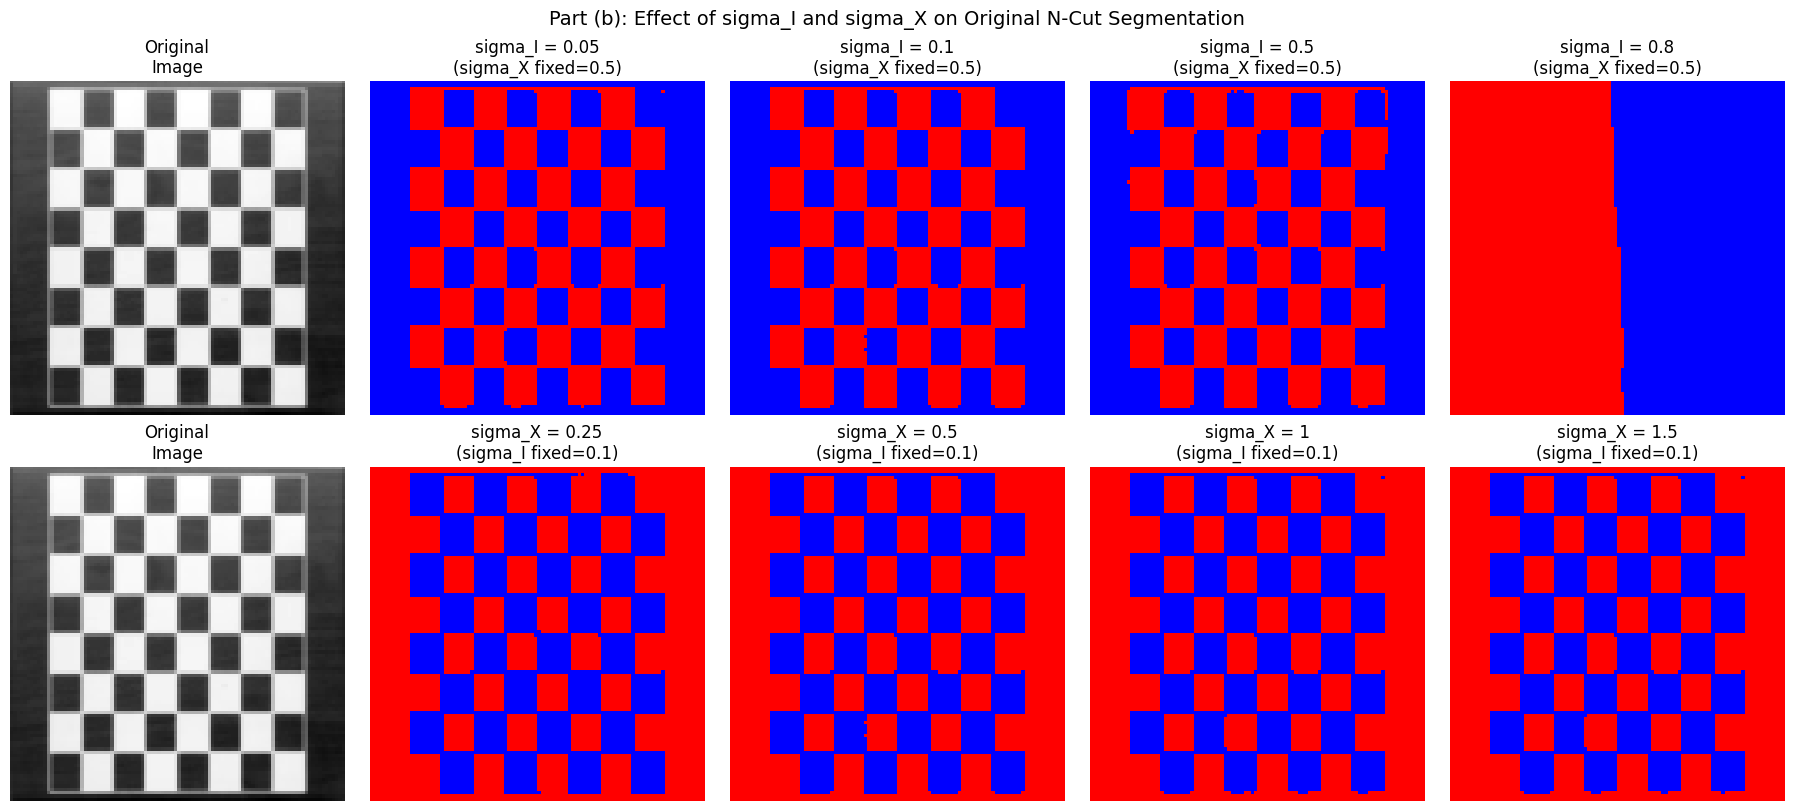

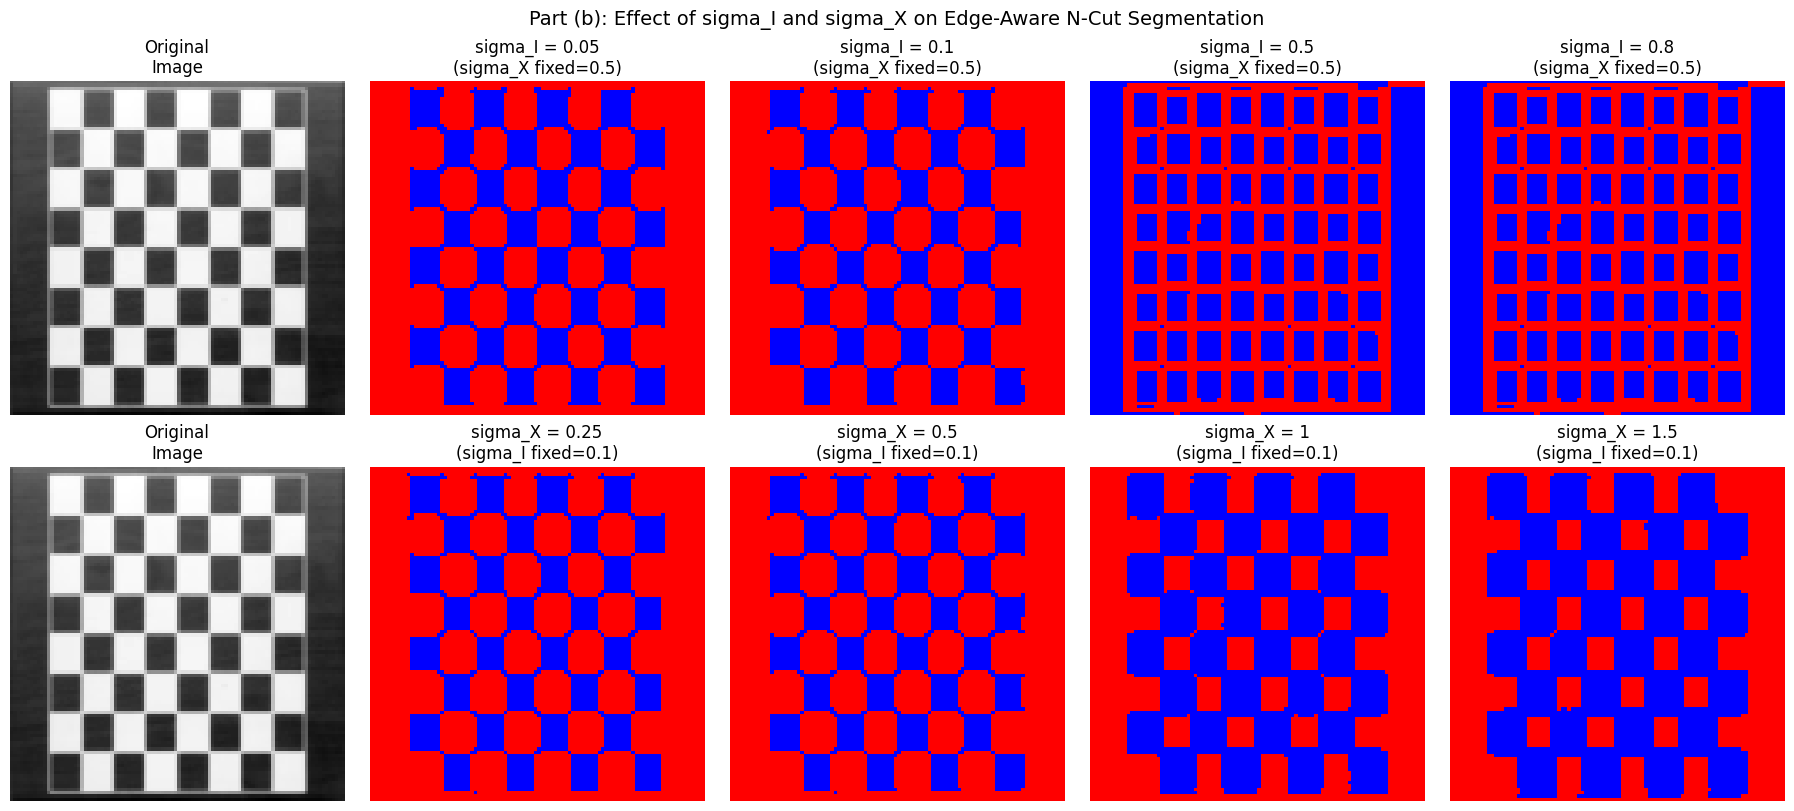

Processing image: Football
    Varying sigma_I with sigma_X = 0.5 fixed...
        sigma_I = 0.05
        sigma_I = 0.1
        sigma_I = 0.5
        sigma_I = 0.8
    Varying sigma_X with sigma_I = 0.1 fixed...
        sigma_X = 0.25
        sigma_X = 0.5
        sigma_X = 1
        sigma_X = 1.5


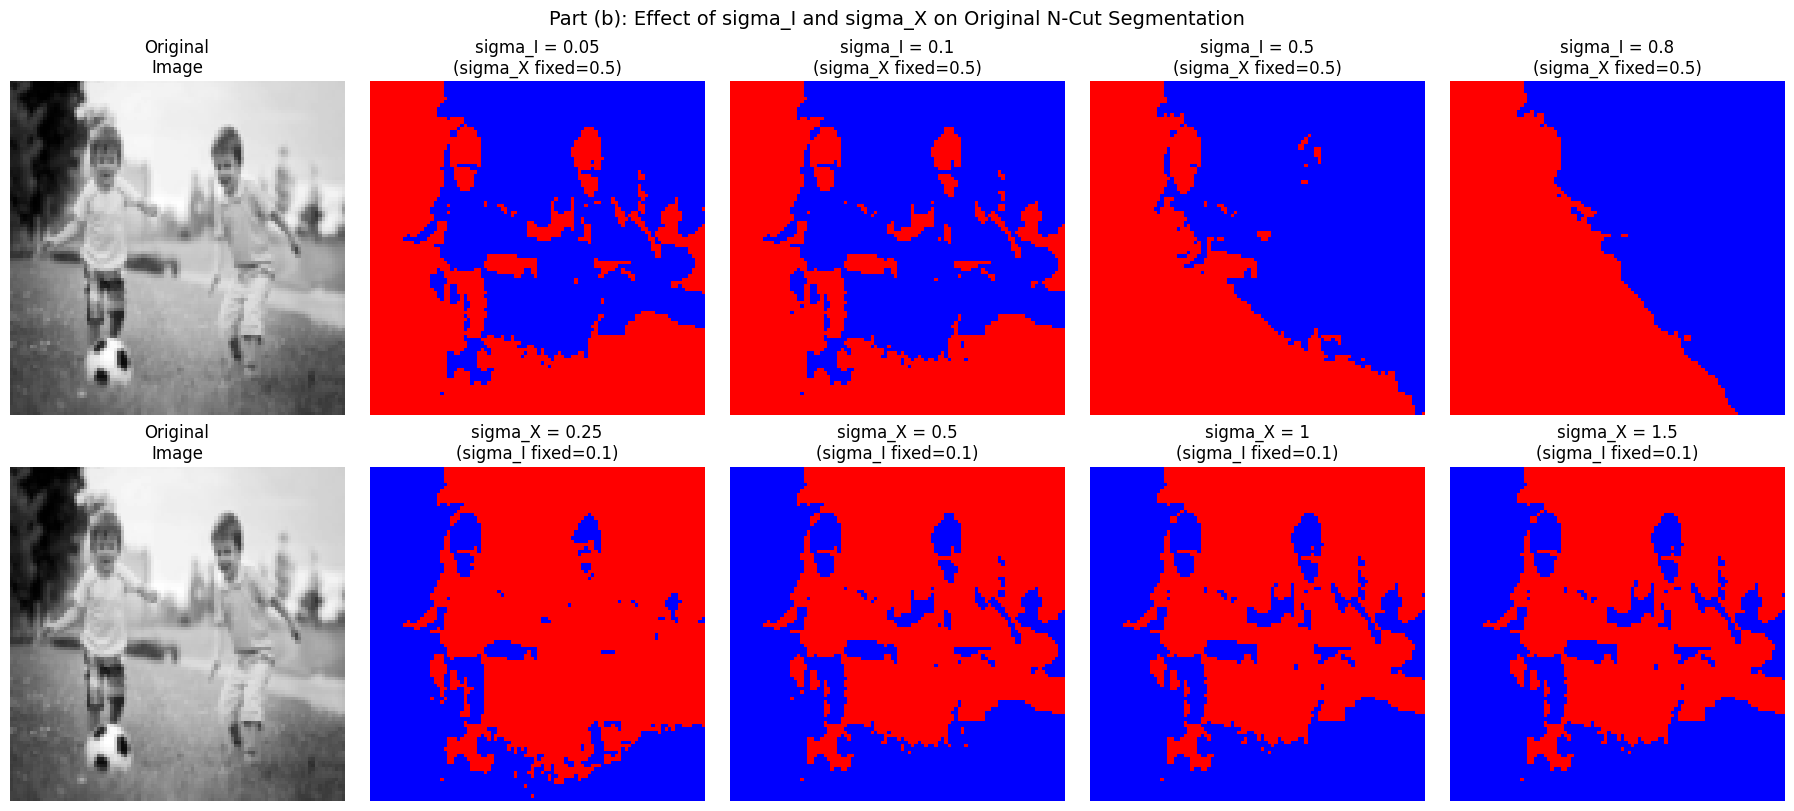

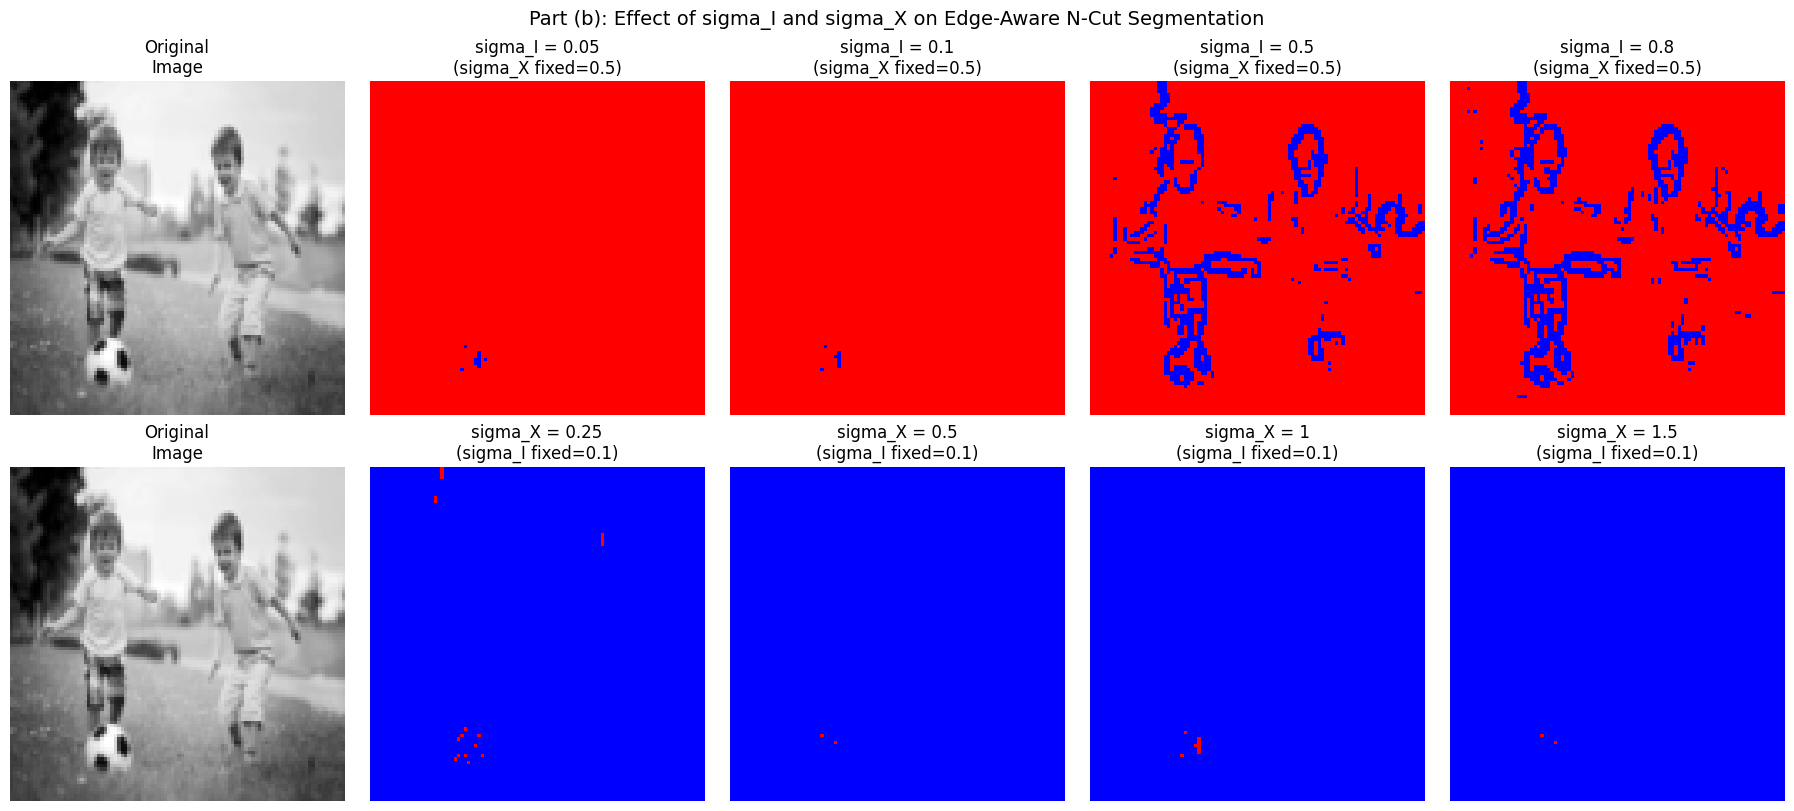

Processing image: Zebra
    Varying sigma_I with sigma_X = 0.5 fixed...
        sigma_I = 0.05
        sigma_I = 0.1
        sigma_I = 0.5
        sigma_I = 0.8
    Varying sigma_X with sigma_I = 0.1 fixed...
        sigma_X = 0.25
        sigma_X = 0.5
        sigma_X = 1
        sigma_X = 1.5


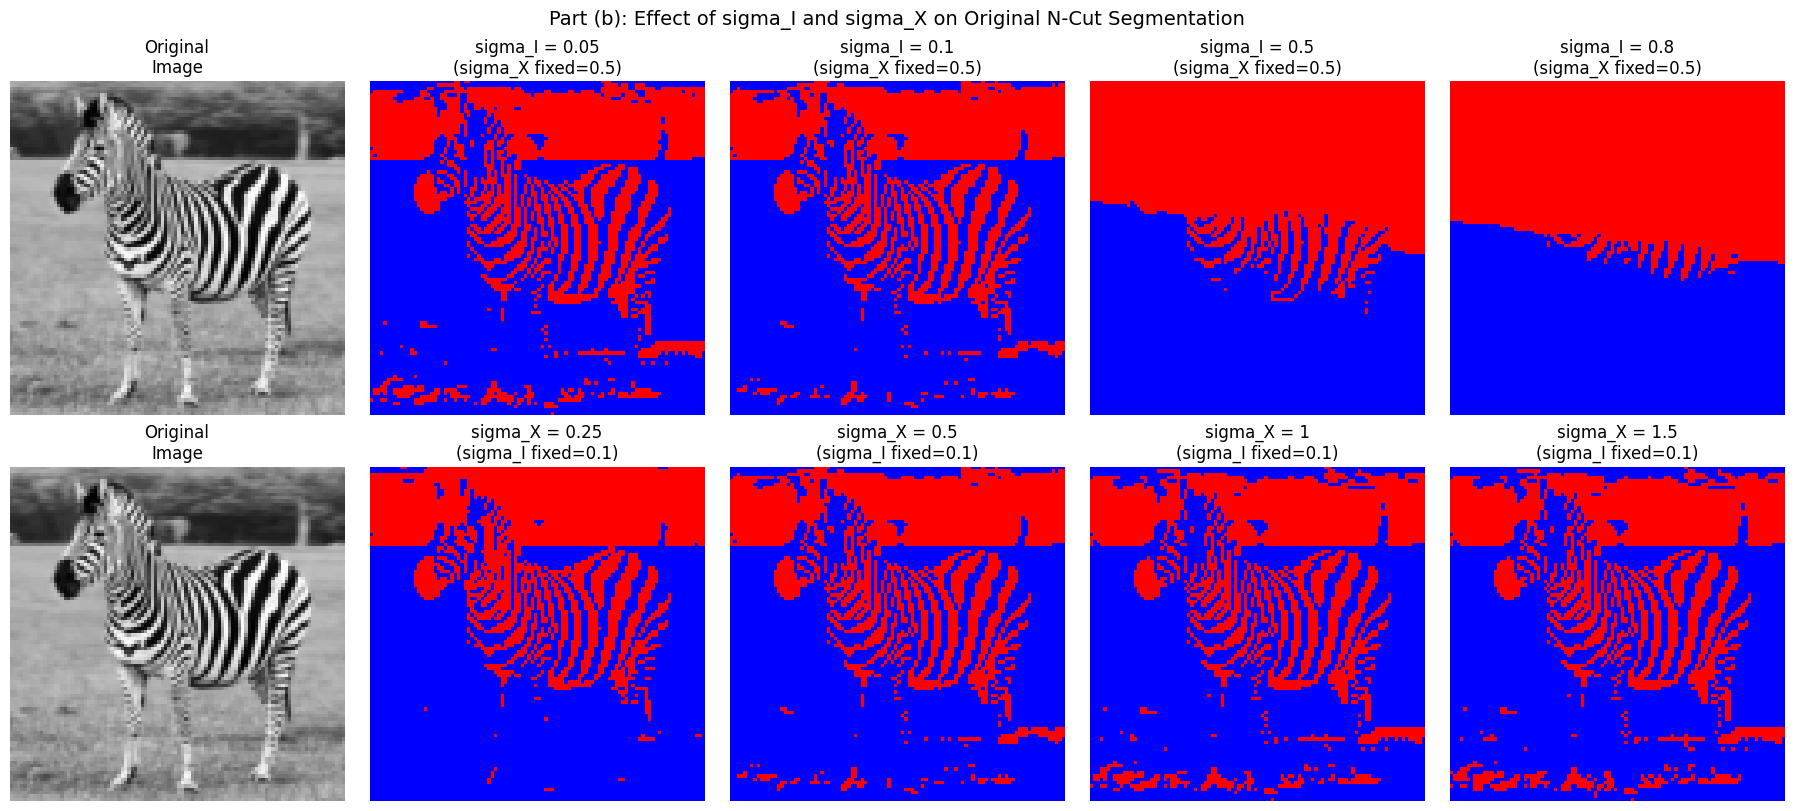

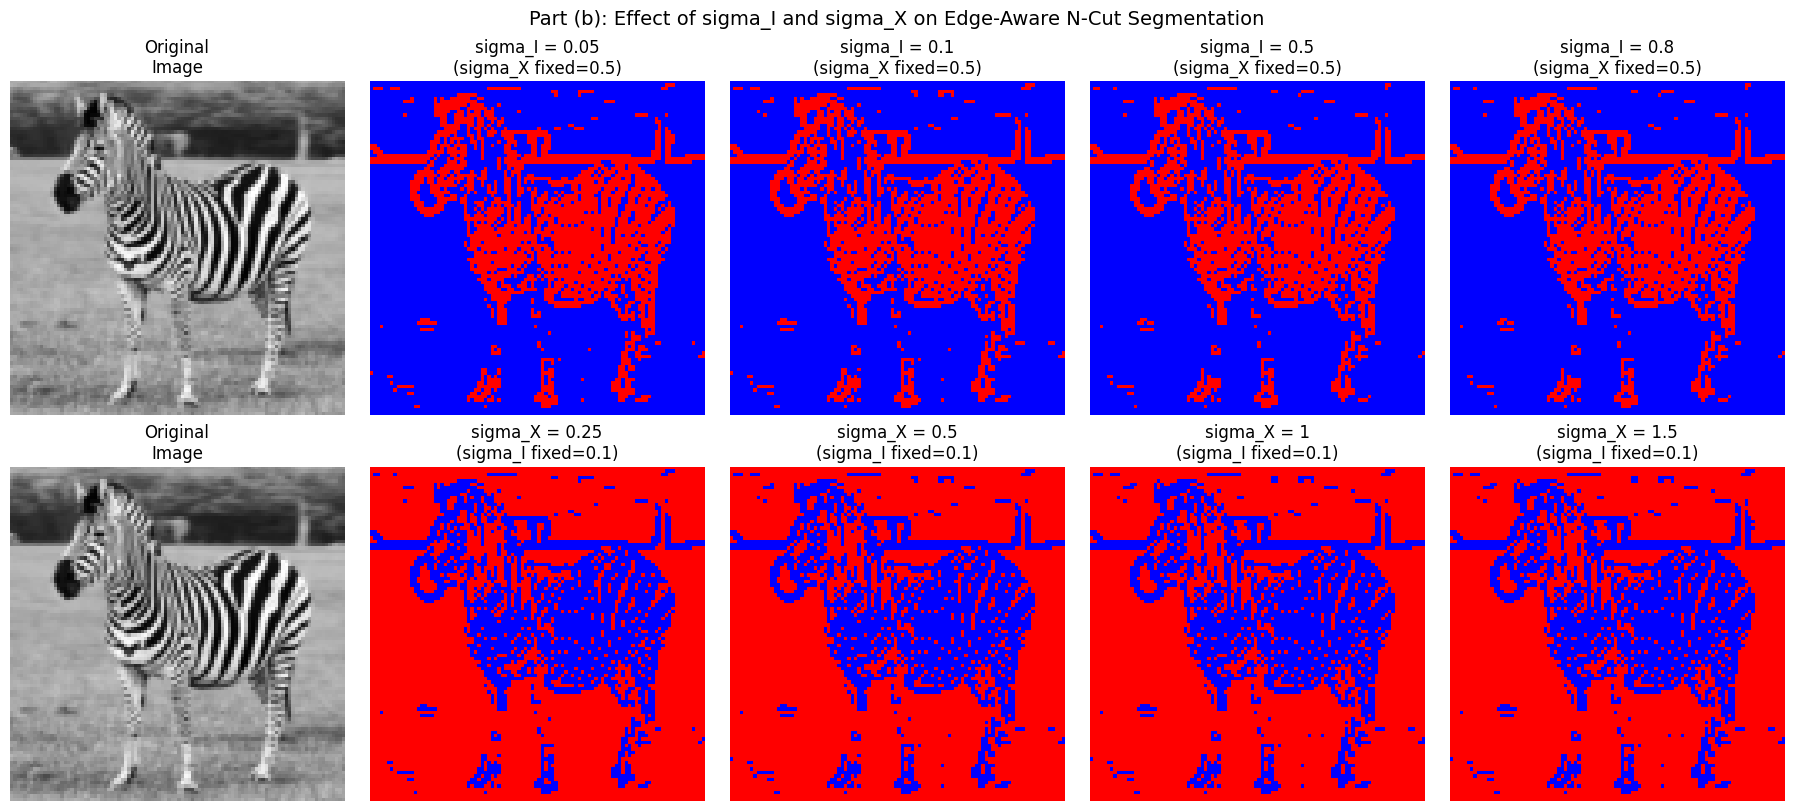

In [17]:
for i in range(len(images)):
    img, name = images[i], image_names[i]
    print(f"Processing image: {name}")
    segs_orginal_vary_sigmaI, segs_modified_vary_sigmaI  = get_seg_maps_vary_sigma(img=img, fixed_sigma=sigma_X_fixed, vary_sigma_values=sigma_I_values, fixed_sigma_name="sigma_X", vary_sigma_name="sigma_I")
    segs_orginal_vary_sigmaX, segs_modified_vary_sigmaX = get_seg_maps_vary_sigma(img=img, fixed_sigma=sigma_I_fixed, vary_sigma_values=sigma_X_values, fixed_sigma_name="sigma_I", vary_sigma_name="sigma_X")

    plot_varying_sigma_effect(segs_orginal_vary_sigmaI, segs_orginal_vary_sigmaX, affinity="Original", filename = f'part_b_original_affinity_{name}.png')
    plot_varying_sigma_effect(segs_modified_vary_sigmaI, segs_modified_vary_sigmaX, affinity="Edge-Aware", filename = f'part_b_edge_aware_affinity_{name}.png')

---
## Part (c): Multi-way Segmentation

In [18]:
# SIGMA_I = .2
# SIGMA_X = 5
SIGMA_I = 0.1
SIGMA_X = 0.5
SIGMA_E = 0.01
NCUT_THRESHOLD = 1
N_SEGMENTS = 4

In [19]:
# Returns (eigenvalues, eigenvectors)- sorted in ascending order
def solve_eigensystem_sub(W_sp, k):
    d = np.asarray(W_sp.sum(axis=1)).reshape(-1)
    d = np.maximum(d, 1e-12)
    D_isqrt = sparse.diags(1.0 / np.sqrt(d))
    L_sym = D_isqrt @ (sparse.diags(d) - W_sp) @ D_isqrt

    n = W_sp.shape[0]
    k_eff = min(max(2, k), n - 1)
    vals, vecs = eigsh(L_sym, k=k_eff, which='SM', tol=1e-3)

    order = np.argsort(vals)
    return vals[order], vecs[:, order]

### Recursive Implementation

In [20]:
def compute_ncut_value(mask, W_sp):
    B = ~mask
    if mask.sum() == 0 or B.sum() == 0:
        return np.inf
    d = np.asarray(W_sp.sum(axis=1)).reshape(-1)
    assoc_A = d[mask].sum()
    assoc_B = d[B].sum()
    if assoc_A <= 0 or assoc_B <= 0:
        return np.inf
    cut_AB = W_sp[mask][:, B].sum()
    return float(cut_AB / assoc_A + cut_AB / assoc_B)

# Returns (best_mask, best_ncut).  best_mask is None if no valid split found
def best_threshold_split(fiedler, W_sp, min_size, n_thresholds):
    vmin, vmax = float(fiedler.min()), float(fiedler.max())
    if np.isclose(vmin, vmax):
        return None, np.inf

    grid = np.linspace(vmin, vmax, n_thresholds + 2)[1:-1]
    extras = np.array([0.0, float(np.median(fiedler)), float(np.mean(fiedler))])
    thresholds = np.unique(np.concatenate([grid, extras]))

    best_mask, best_score = None, np.inf
    for t in thresholds:
        mask = fiedler > t
        if mask.sum() < min_size or (~mask).sum() < min_size:
            continue
        score = compute_ncut_value(mask, W_sp)
        if score < best_score:
            best_score = score
            best_mask  = mask.copy()

    return best_mask, best_score

In [21]:
def recursive_ncut(image, W_full, n_segments=N_SEGMENTS, ncut_threshold=NCUT_THRESHOLD):
    H, W = image.shape
    N = H * W

    min_region_ratio = 0.02
    min_size = max(8, int(min_region_ratio * N))

    n_thresholds = 30

    # list of regions - pixel index arrays.
    regions = [np.arange(N)]

    while len(regions) < n_segments:
        split_done = False

        # split the largest region
        for ridx in sorted(range(len(regions)), key=lambda i: regions[i].size, reverse=True):
            region = regions[ridx]
            if region.size < 2 * min_size:
                continue

            # subgraph for this region
            W_sub = W_full[region][:, region]

            _, vecs = solve_eigensystem_sub(W_sub, k=2)
            fiedler = np.asarray(vecs[:, 1]).flatten()

            # Find best split threshold 
            mask_sub, best_ncut = best_threshold_split(fiedler, W_sub, min_size=min_size, n_thresholds=n_thresholds)

            # Reject if Ncut too large or no valid split found
            if mask_sub is None or best_ncut > ncut_threshold:
                continue

            A = region[mask_sub]
            B = region[~mask_sub]
            if A.size < min_size or B.size < min_size:
                continue

            # Accept the split
            regions.pop(ridx)
            regions.extend([A, B])
            split_done = True
            break

        if not split_done:
            break   # can't split anymore

    labels = np.zeros(N, dtype=np.int32)
    for k, reg in enumerate(regions):
        labels[reg] = k

    return labels.reshape(H, W)

### Simultaneous Implementation

In [22]:
def simultaneous_ncut(W_full, image_shape, n_segments=N_SEGMENTS, random_state=42):
    H, W = image_shape

    # evecs
    _, vecs = solve_eigensystem_sub(W_full, k=n_segments + 1)
    Z = np.asarray(vecs[:, 1:n_segments + 1])

    # k means
    km     = KMeans(n_clusters=n_segments, n_init=10, random_state=random_state)
    labels = km.fit_predict(Z)
    return labels.reshape(H, W)

### Comparison of the two methods

In [23]:
results_c = []

for img, name in zip(images, image_names):
    print(f'\nProcessing {name}...')

    W_I, W_X, W_E = build_image_features(image=img, sigma_I=SIGMA_I, sigma_X=SIGMA_X)
    W_full = build_affinity_matrix_original(W_I, W_X)

    seg_rec = recursive_ncut(img, W_full, n_segments=N_SEGMENTS, ncut_threshold=NCUT_THRESHOLD)

    seg_sim = simultaneous_ncut(W_full, img.shape, n_segments=N_SEGMENTS)

    results_c.append((img, seg_rec, seg_sim, name))


Processing Books...


/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bitupan_arandhara/Deskto


Processing Chess...


/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bitupan_arandhara/Deskto


Processing Football...


/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bitupan_arandhara/Deskto


Processing Zebra...


/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bitupan_arandhara/Desktop/Study/IISc/AIP/aip_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/bitupan_arandhara/Deskto

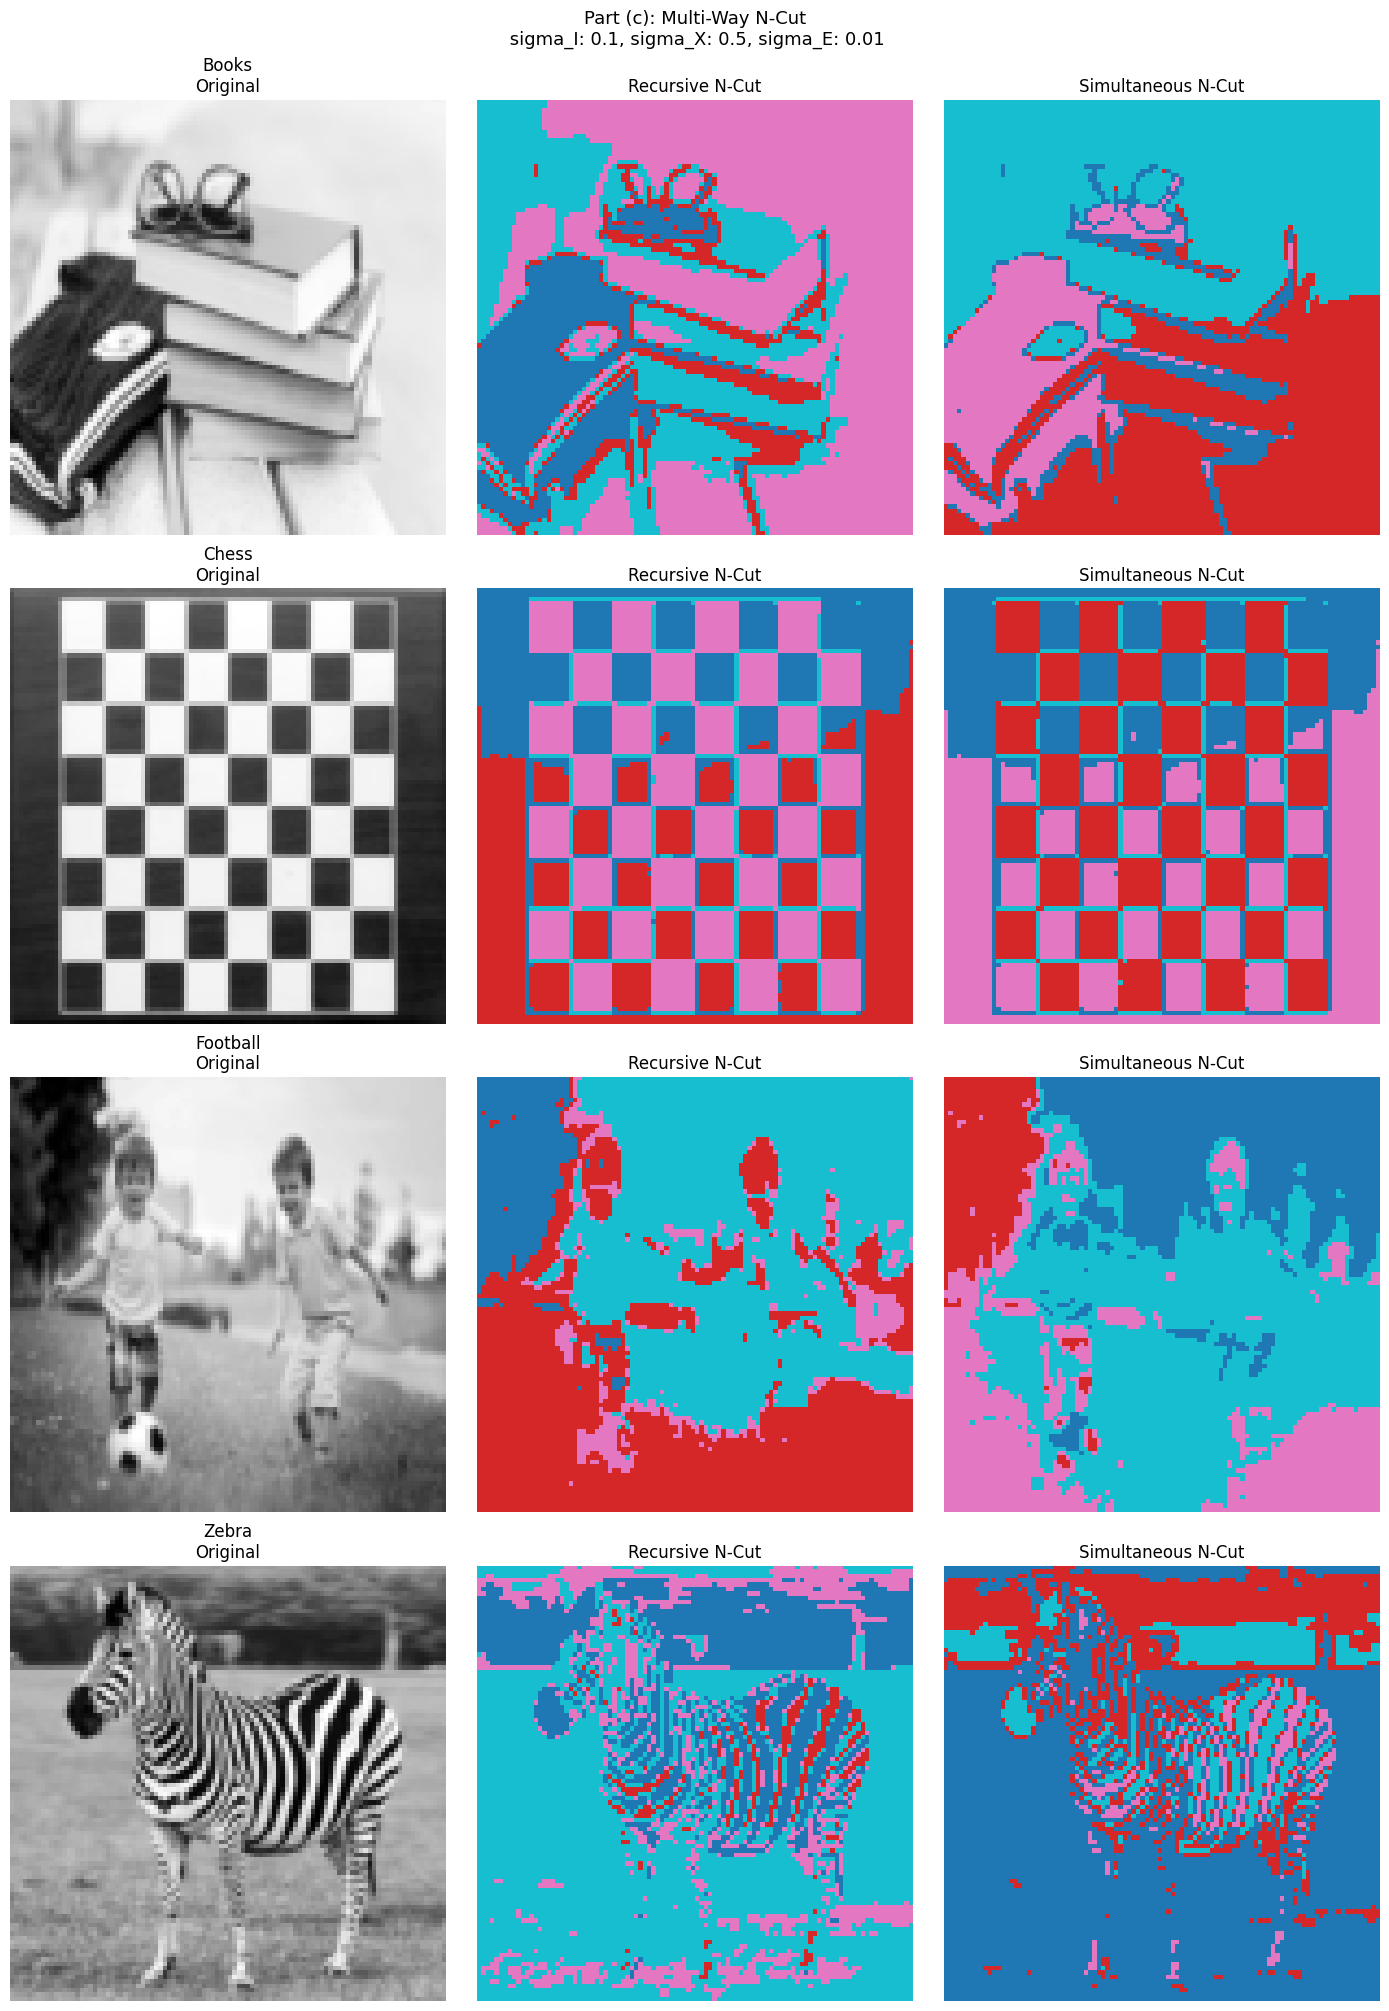

In [26]:
fig, axes = plt.subplots(len(results_c), 3, figsize=(14, 5 * len(results_c)), constrained_layout=True)
if len(results_c) == 1:
    axes = axes[np.newaxis, :]

for r, (img, seg_rec, seg_sim, name) in enumerate(results_c):
    n_rec = len(np.unique(seg_rec))
    n_sim = len(np.unique(seg_sim))

    axes[r, 0].imshow(img, cmap='gray')
    axes[r, 0].set_title(f'{name}\nOriginal')
    axes[r, 0].axis('off')

    axes[r, 1].imshow(seg_rec, cmap='tab10', vmin=0, vmax=N_SEGMENTS - 1)
    axes[r, 1].set_title(f'Recursive N-Cut')
    axes[r, 1].axis('off')

    axes[r, 2].imshow(seg_sim, cmap='tab10', vmin=0, vmax=N_SEGMENTS - 1)
    axes[r, 2].set_title(f'Simultaneous N-Cut')
    axes[r, 2].axis('off')

fig.suptitle(f'Part (c): Multi-Way N-Cut\n sigma_I: {SIGMA_I}, sigma_X: {SIGMA_X}, sigma_E: {SIGMA_E}', fontsize=13)
plt.savefig(output_path + 'part_c_results.png', dpi=140, bbox_inches='tight')
plt.show()